# Template - Détection de la pneumonie à partir d'images radiologiques - Classification avec multiples classes
Ce template est une piste de recherche pour la classification des radios normales, virales ou bactériennes. Il présente un cas qui semble fonctionner mais qui n'est pas optimal, car présentant de l'overfitting. L'ensemble des modifications sont listées dans le notebook tem_2_categorical_classification_overfit_2_v2.ipynb.

In [1]:
# Check that GPU is used
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test_modified'
val_folder = 'val_modified'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'VIRUS', 'BACTERIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 224, 224

In [3]:
def split_virus_bacteria_pneumonia(folder):
    temp_subfolders = ['NORMAL', 'VIRUS', 'BACTERIA', 'PNEUMONIA']

    # Create the subfolders if they don't exist
    for subfolder in subfolders:
        if not os.path.exists(os.path.join(folder, subfolder)):
            os.makedirs(os.path.join(folder, subfolder))

    # Move the images to the corresponding subfolder
    for subfolder in temp_subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        if subfolder == 'PNEUMONIA':
            for filename in os.listdir(subfolder_path):
                if 'virus' in filename:
                    os.rename(os.path.join(subfolder_path, filename), os.path.join(folder, 'VIRUS', filename))
                elif 'bacteria' in filename:
                    os.rename(os.path.join(subfolder_path, filename), os.path.join(folder, 'BACTERIA', filename))
        else:
            for filename in os.listdir(subfolder_path):
                os.rename(os.path.join(subfolder_path, filename), os.path.join(folder, subfolder, filename))

In [4]:
# Split the pneumonia folder into virus and bacteria subfolders
split_virus_bacteria_pneumonia(train_folder)

# Split the pneumonia folder into virus and bacteria subfolders
split_virus_bacteria_pneumonia(test_folder)

# Split the pneumonia folder into virus and bacteria subfolders
split_virus_bacteria_pneumonia(val_folder)

In [5]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [6]:
# Generate augmented for the training set
from common.data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'BACTERIA', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'VIRUS', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 20000
Found 2529 images belonging to 1 classes.
Additional count of images to generate: 0
Given BACTERIA count: 2529
Augmented BACTERIA count: 20000
Found 1345 images belonging to 1 classes.
Additional count of images to generate: 0
Given VIRUS count: 1345
Augmented VIRUS count: 20000


In [7]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))), len(os.listdir(os.path.join(train_folder, subfolders[2]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

In [8]:
# One-hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

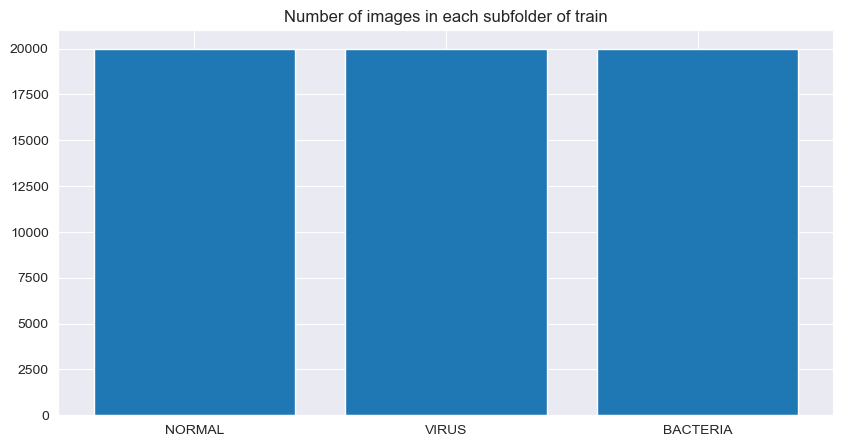

In [9]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

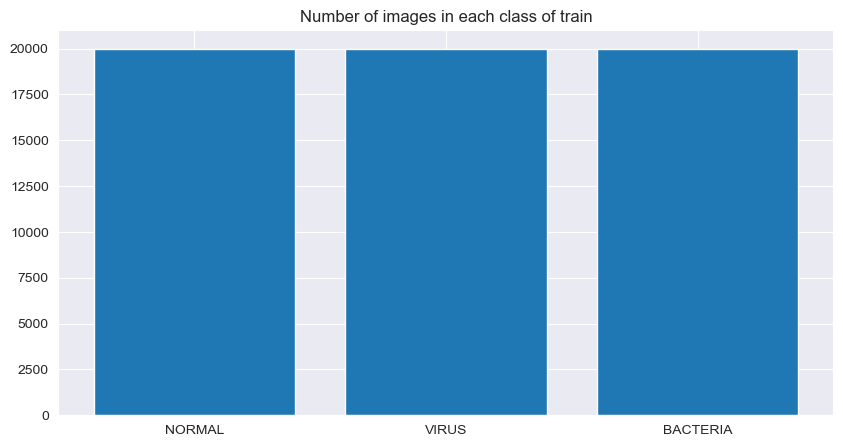

In [10]:
# Make a matplot figure to show how many images if each class in the training set considering it is hot-encoded
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [sum(y_train[:, i]) for i in range(len(subfolders))])
plt.title('Number of images in each class of train')
plt.show()

In [11]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(224, 224, 1)
[0. 0. 1.]


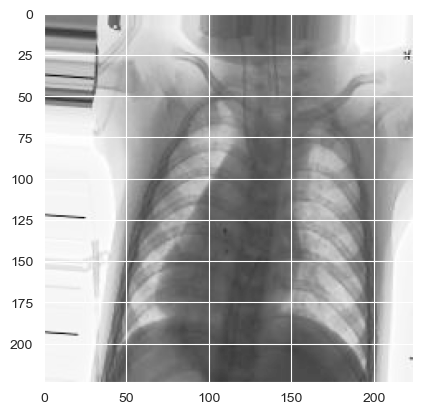

In [12]:
random_int = np.random.randint(len(X_train))
single_image = X_train[random_int]
print(single_image.shape)
print(y_train[random_int])
plt.imshow(single_image, cmap='Greys')

In [13]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(len(subfolders), activation="softmax"))

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [16]:
# Cross validation
from keras.preprocessing.image import ImageDataGenerator

# Define the number of folds for cross-validation
n_splits = 10
epochs = 7
batch_size = 128

In [17]:
from sklearn.model_selection import KFold
# Initialize KFold with the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []
models = []

# Iterate through each fold and train/evaluate the model
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Print number of labels in each class for the training and validation sets for this fold
    print('Number of labels in each class for training set for this fold:', [sum(y_train_fold[:, i]) for i in range(len(subfolders))])
    print('Number of labels in each class for validation set for this fold:', [sum(y_val_fold[:, i]) for i in range(len(subfolders))])

    # Create an instance of ImageDataGenerator to generate your image data
    datagen = ImageDataGenerator()

    # Create generators for training and validation data
    train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=batch_size, ignore_class_split=True)
    valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=batch_size)

    # Create instance of the model for this fold and train it
    model = create_model()

    # Train your model on the training data for this fold
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
    histories.append(history.history)

    models.append(model)


Number of labels in each class for training set for this fold: [18005.0, 17951.0, 18044.0]
Number of labels in each class for validation set for this fold: [1995.0, 2049.0, 1956.0]
Epoch 1/7
422/422 [==============================] - 72s 162ms/step - loss: 0.7300 - accuracy: 0.6594 - auc: 0.8486 - val_loss: 0.5679 - val_accuracy: 0.7528 - val_auc: 0.9099
Epoch 2/7
422/422 [==============================] - 59s 139ms/step - loss: 0.5622 - accuracy: 0.7506 - auc: 0.9104 - val_loss: 0.5219 - val_accuracy: 0.7708 - val_auc: 0.9233
Epoch 3/7
422/422 [==============================] - 58s 137ms/step - loss: 0.5055 - accuracy: 0.7750 - auc: 0.9262 - val_loss: 0.4566 - val_accuracy: 0.7923 - val_auc: 0.9387
Epoch 4/7
422/422 [==============================] - 55s 131ms/step - loss: 0.4643 - accuracy: 0.7929 - auc: 0.9369 - val_loss: 0.4546 - val_accuracy: 0.7908 - val_auc: 0.9387
Epoch 5/7
422/422 [==============================] - 59s 140ms/step - loss: 0.4359 - accuracy: 0.8026 - auc: 0.9439

MemoryError: Unable to allocate 10.1 GiB for an array with shape (54000, 224, 224, 1) and data type float32

In [18]:
# Get accuracy scores for each fold (train and validation)
loss = []
acc = []
val_loss = []
val_acc = []

for history in histories:
    loss.append(np.mean(history["loss"]))
    acc.append(np.mean(history["accuracy"]))
    val_loss.append(np.mean(history["val_loss"]))
    val_acc.append(np.mean(history["val_accuracy"]))

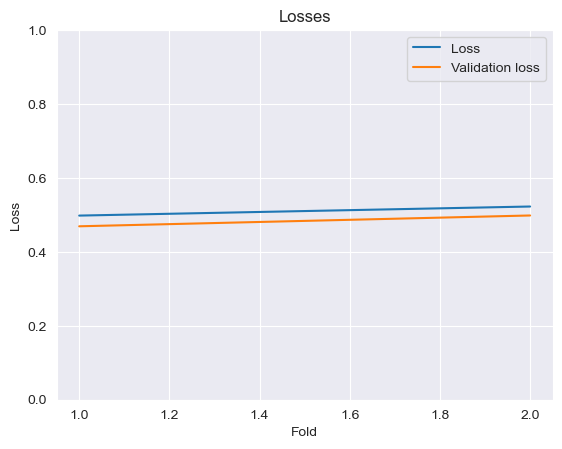

In [19]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(loss)+1), loss, label='Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

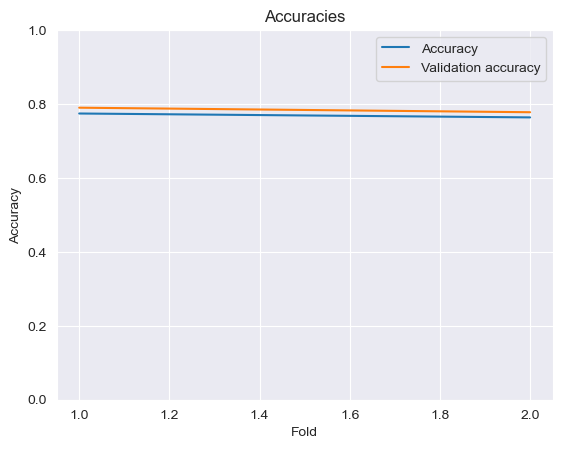

In [20]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Train a final model with same parameters and save it
datagen = ImageDataGenerator()
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=batch_size)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=batch_size)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/7
469/469 [==============================] - 71s 150ms/step - loss: 0.7117 - accuracy: 0.6718 - auc: 0.8662 - val_loss: 0.5475 - val_accuracy: 0.8503 - val_auc: 0.9411
Epoch 2/7
469/469 [==============================] - 65s 138ms/step - loss: 0.5641 - accuracy: 0.7489 - auc: 0.9097 - val_loss: 0.5499 - val_accuracy: 0.8602 - val_auc: 0.9335
Epoch 3/7
469/469 [==============================] - 65s 139ms/step - loss: 0.5046 - accuracy: 0.7751 - auc: 0.9263 - val_loss: 0.5373 - val_accuracy: 0.8536 - val_auc: 0.9340
Epoch 4/7
469/469 [==============================] - 63s 134ms/step - loss: 0.4689 - accuracy: 0.7891 - auc: 0.9356 - val_loss: 0.4943 - val_accuracy: 0.8717 - val_auc: 0.9407
Epoch 5/7
469/469 [==============================] - 63s 133ms/step - loss: 0.4425 - accuracy: 0.7987 - auc: 0.9419 - val_loss: 0.5514 - val_accuracy: 0.8536 - val_auc: 0.9354
Epoch 6/7
469/469 [==============================] - 64s 136ms/step - loss: 0.4147 - accuracy: 0.8091 - auc: 0.9486 - va

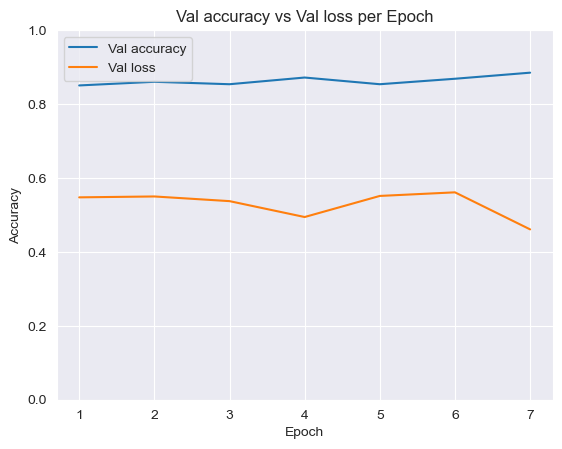

In [34]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Val accuracy vs Val loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Val accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Val loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

19/19 [==============================] - 0s 19ms/step


In [38]:
# convert one-hot encoded y_test to class labels
y_test_labels = np.argmax(y_test, axis=1)

# convert y_pred_test to class labels
y_pred_labels = np.argmax(y_pred_test, axis=1)

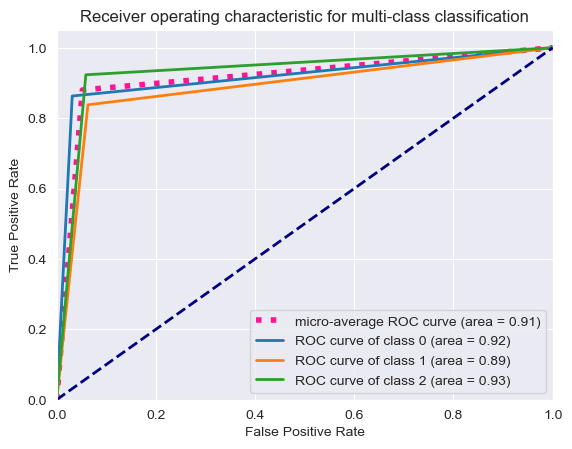

In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(subfolders)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and show AUC score on the plot
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(len(subfolders)):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plot random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot title and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class classification')
plt.legend(loc="lower right")
plt.show()


In [40]:
from sklearn.metrics import confusion_matrix
# compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
print(cm)

[[199  25   2]
 [  4 124  20]
 [ 14   4 216]]


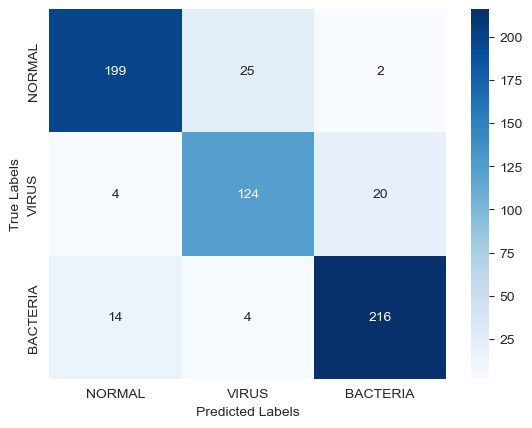

In [41]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [42]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.94      0.86      0.90       226
       VIRUS       0.81      0.84      0.82       148
    BACTERIA       0.91      0.92      0.92       234

   micro avg       0.89      0.88      0.89       608
   macro avg       0.89      0.87      0.88       608
weighted avg       0.90      0.88      0.89       608
 samples avg       0.88      0.88      0.88       608



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


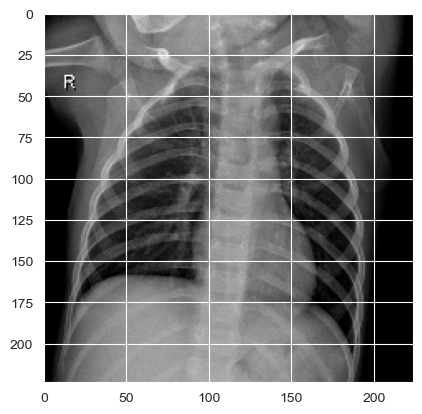

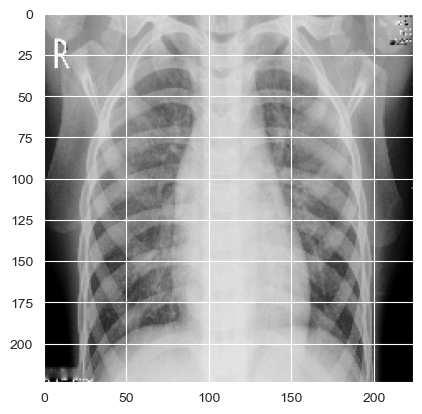

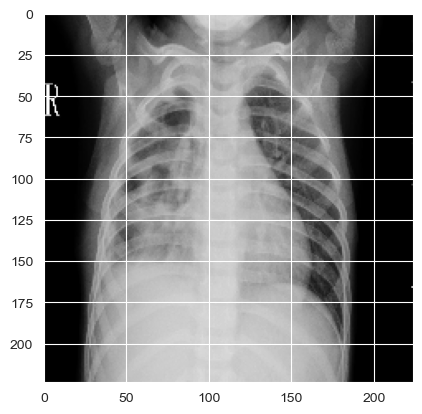

In [51]:
# Heatmaps and Grad-CAM
from common.cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val_modified/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val_modified/VIRUS/person1676_virus_2892.jpeg"
    },
    {
        "path": "./val_modified/BACTERIA/person1954_bacteria_4886.jpeg"
    },
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()
    
    image["array"] = get_img_array(image["path"], size=(img_width, img_height))
    

In [52]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [53]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, None, None, 32)    320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, None, None, 128) 

In [54]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_11"

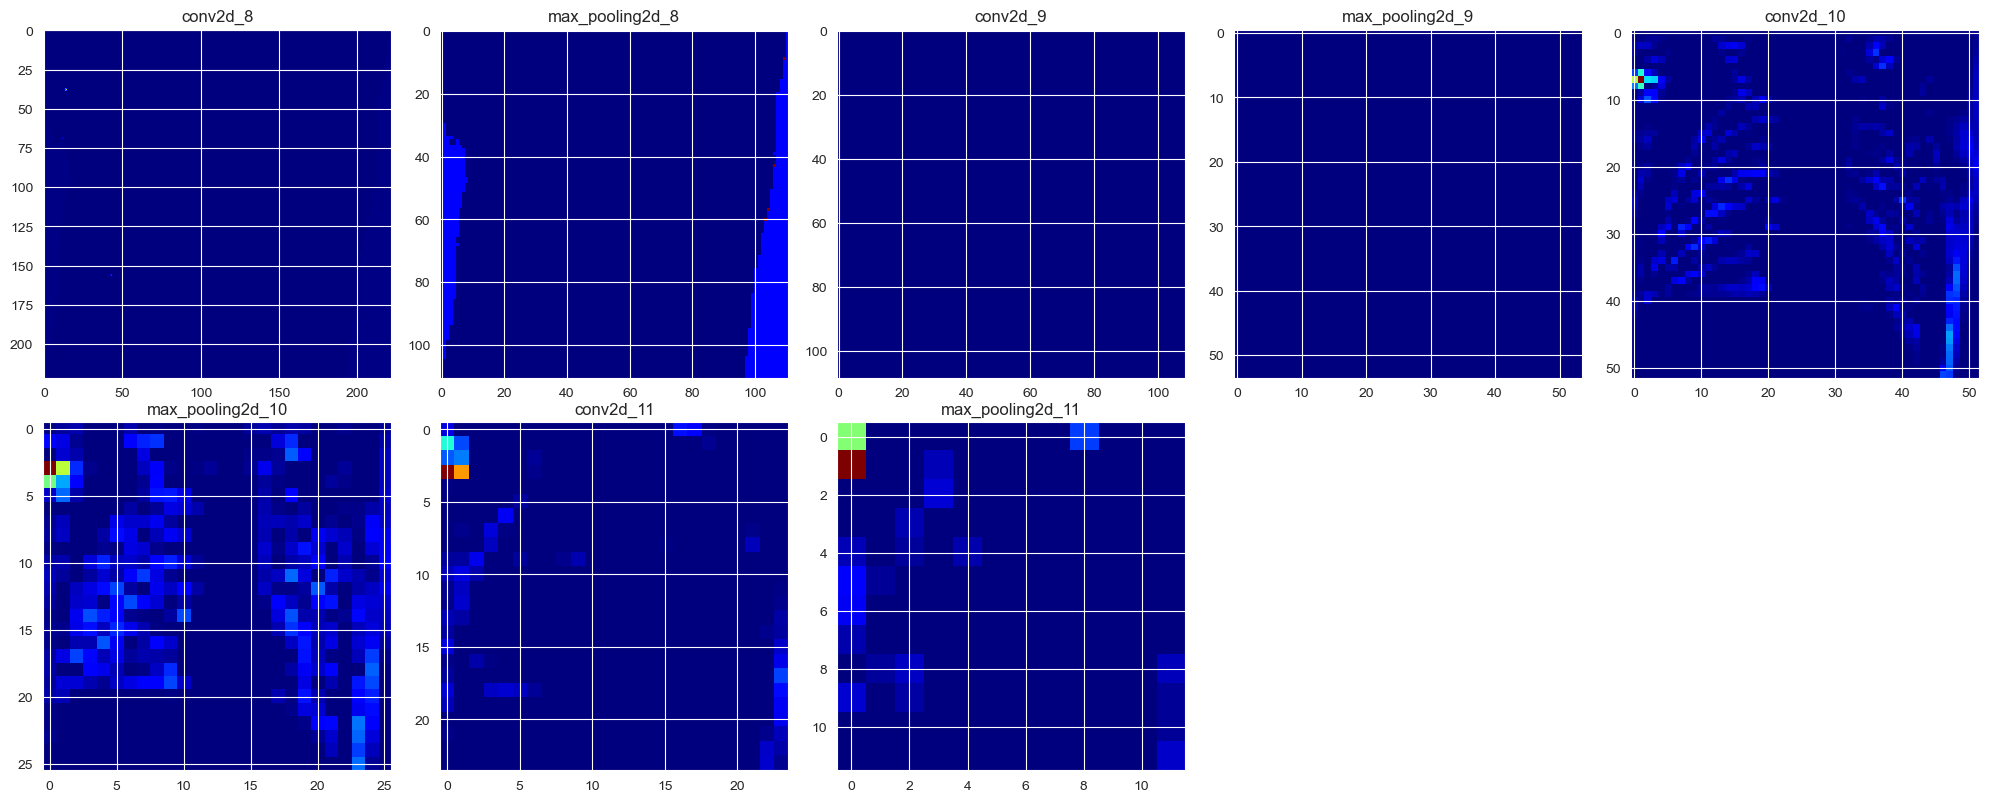

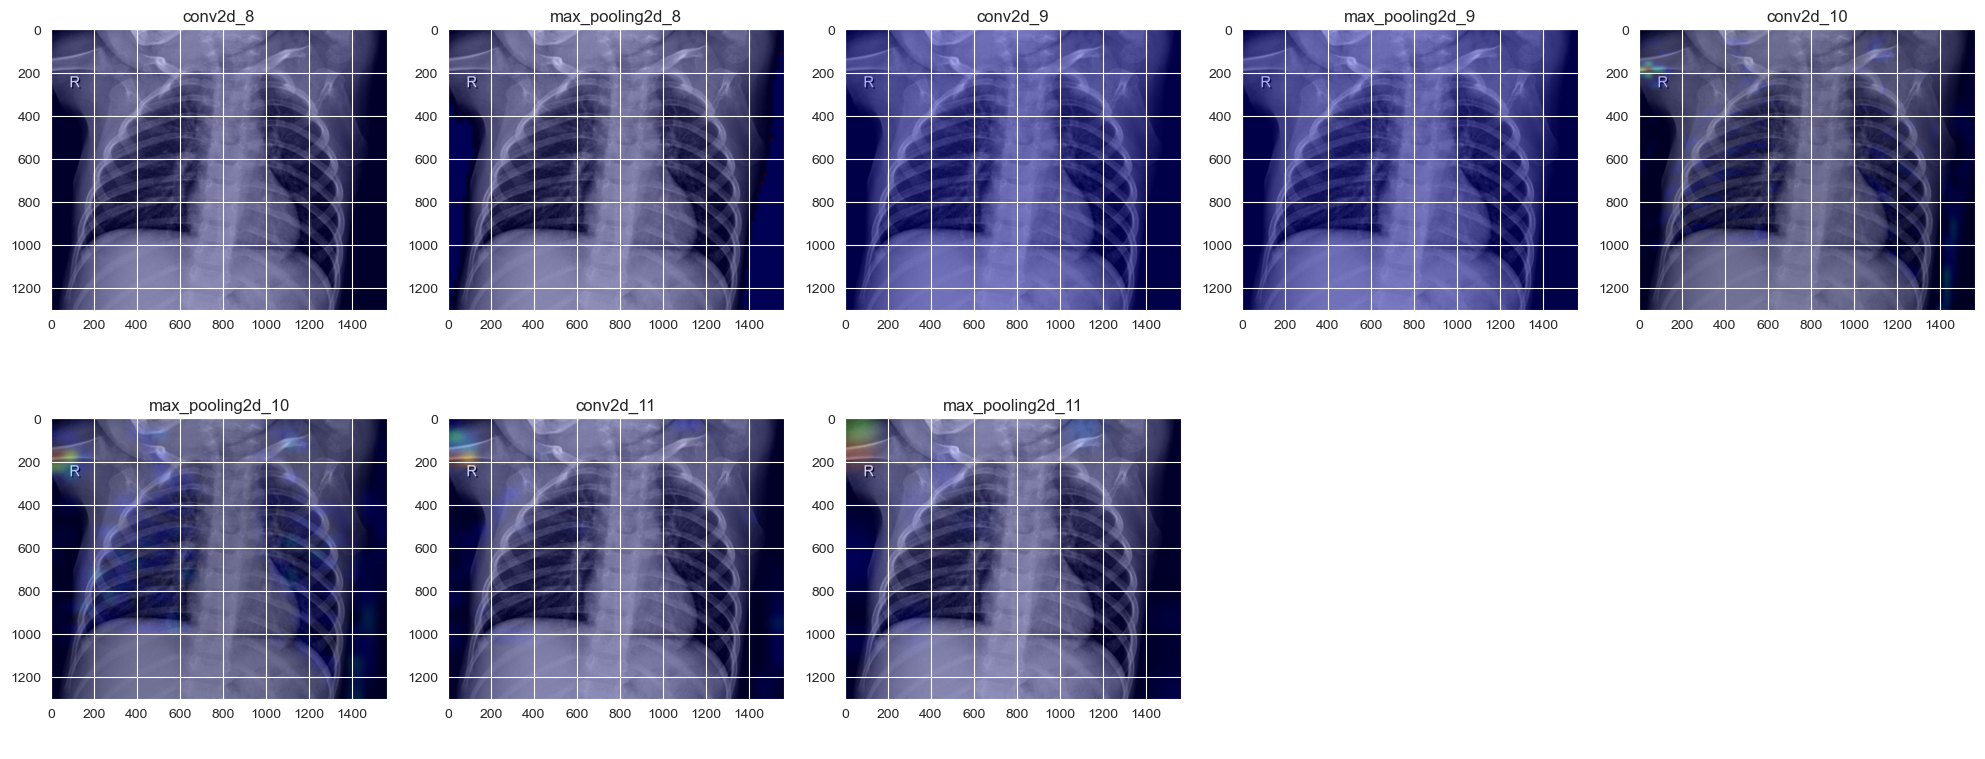

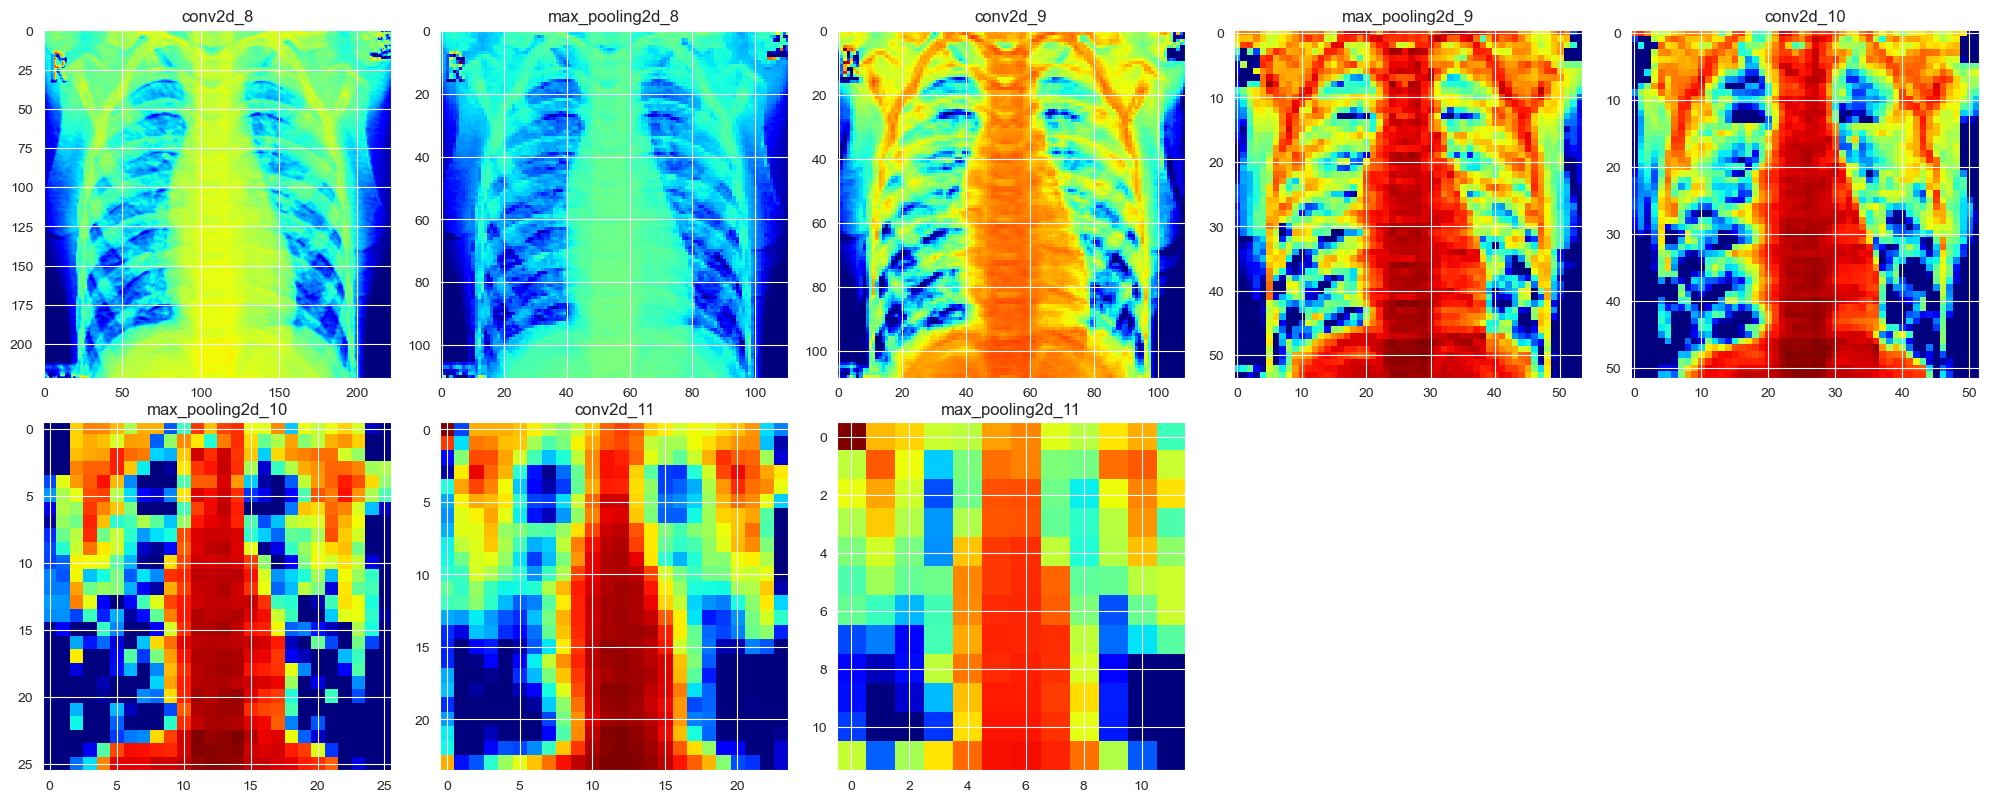

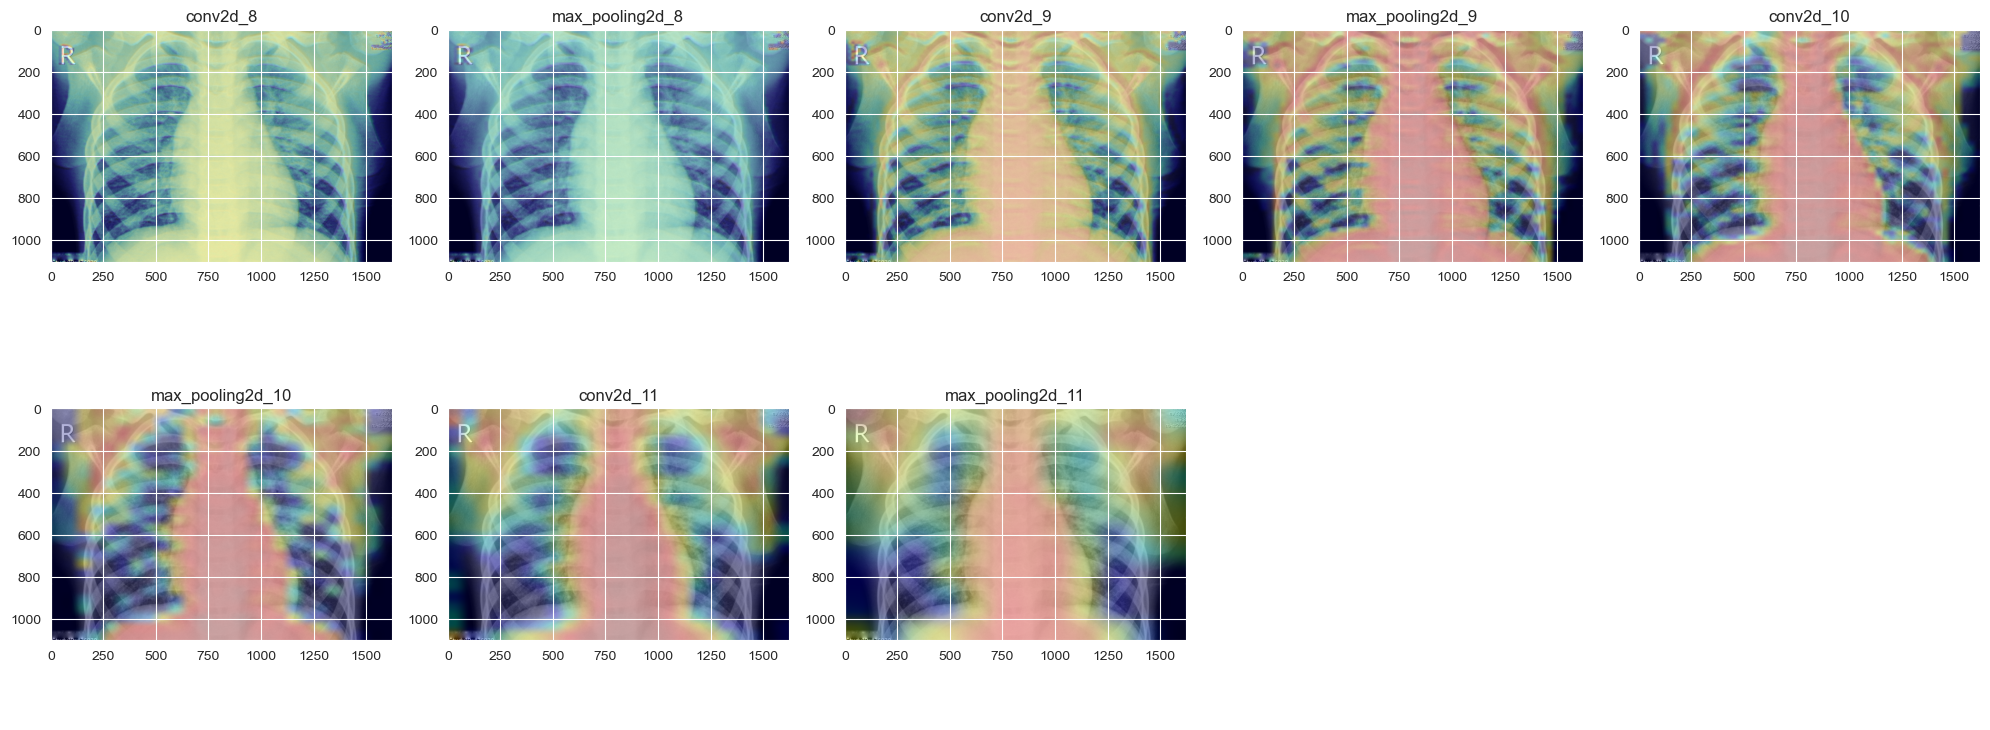

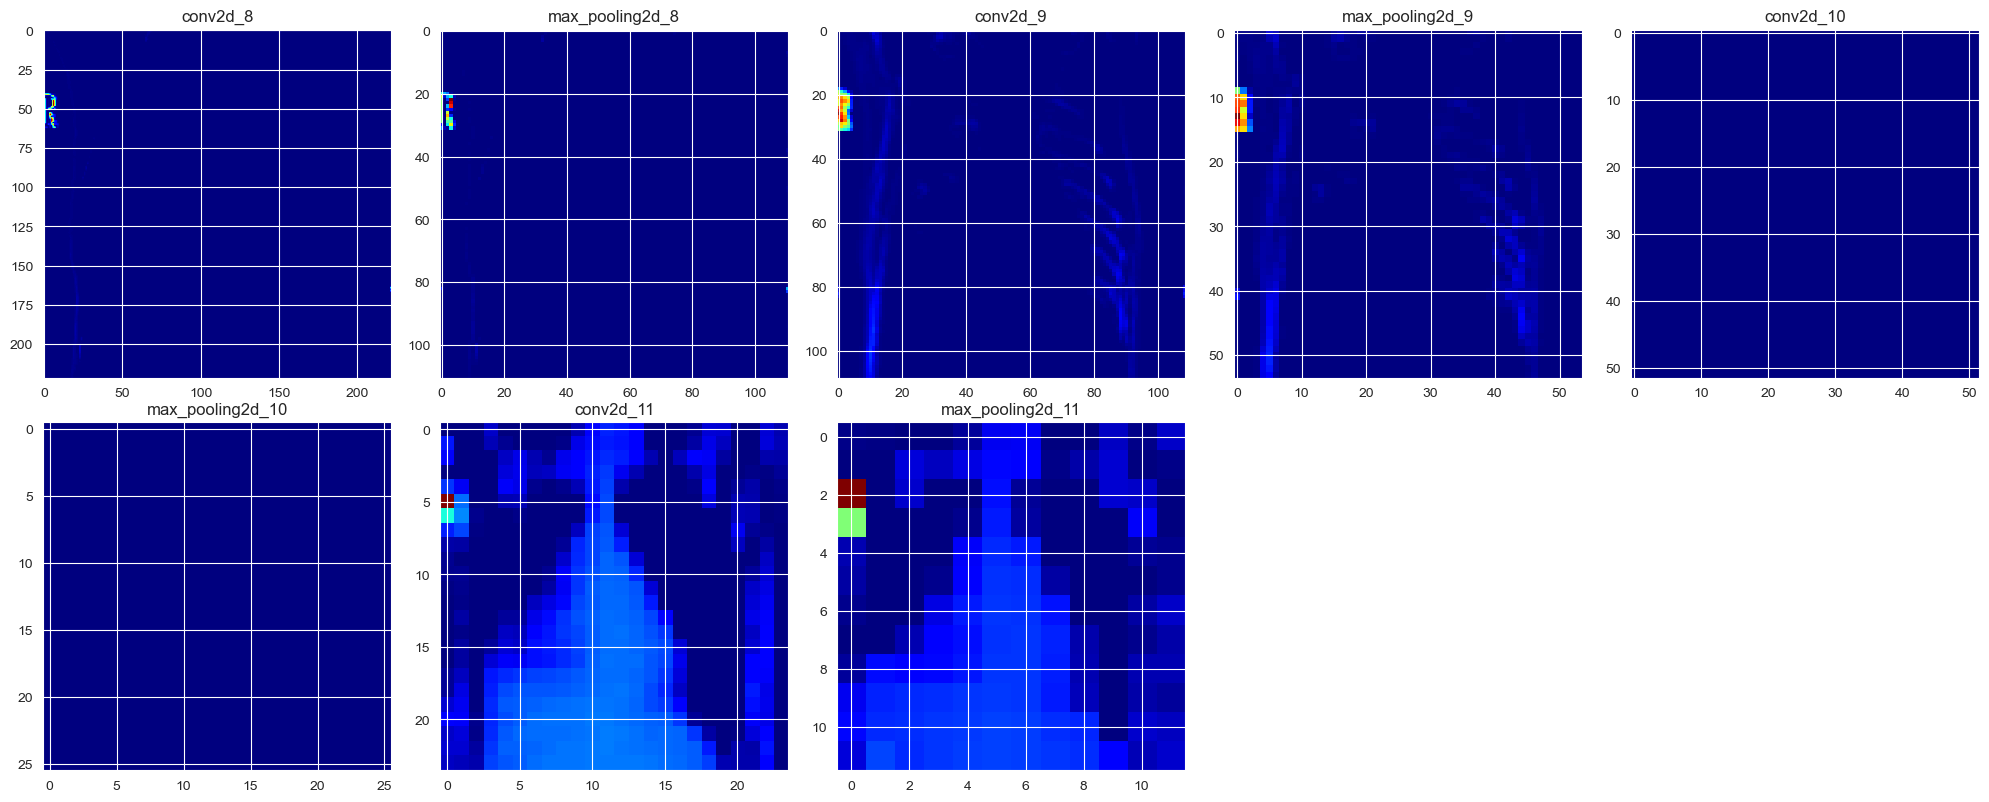

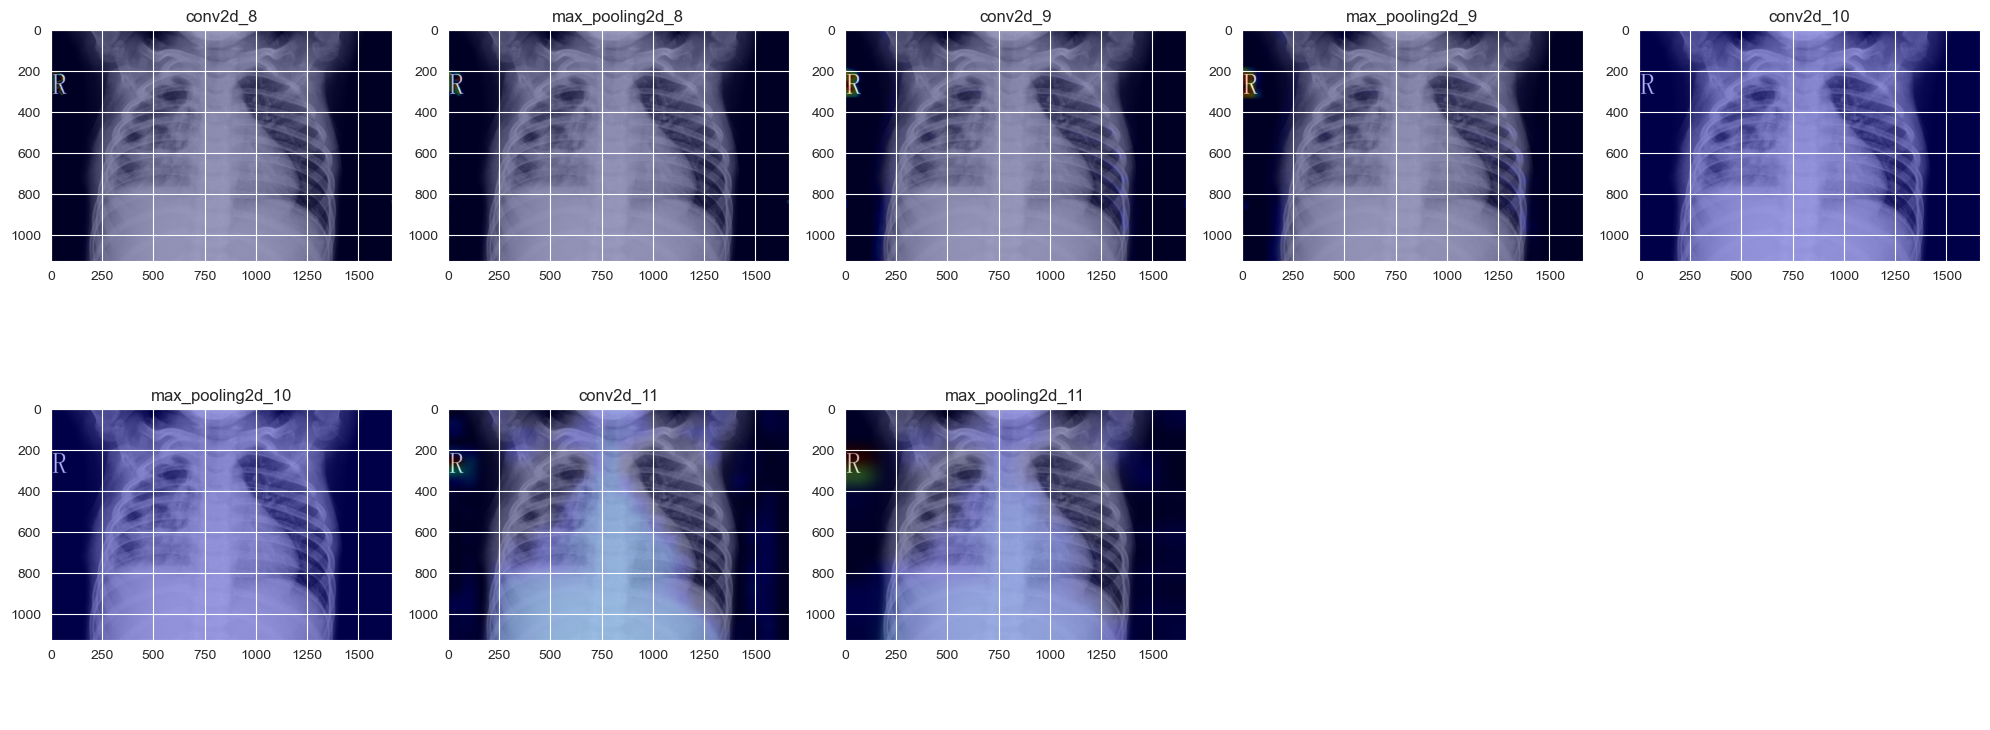

In [55]:
from common.cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [56]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    print(subfolders[np.argmax(pred)])

1/1 [==============================] - 0s 12ms/step
[[ 1214.0726   -399.71176 -1188.9108 ]]
NORMAL
1/1 [==============================] - 0s 12ms/step
[[-3449.8066    772.2781    901.21674]]
BACTERIA
1/1 [==============================] - 0s 11ms/step
[[-3708.3289    983.44617   873.19476]]
VIRUS
